# Compute the Structure Factor and Boson Entropy from the Pair Correlation Function After a Quench

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from collections import defaultdict
import pickle

import dgutils.colors as colortools

style_file = '../include/sf.mplstyle'

with plt.style.context(style_file):
    fig_size = plt.rcParams['figure.figsize'] 
import os
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

### Load useful utilities from disk

In [3]:
import quenchutils as quench

## Load ED data from disk and compute the pair correlation function

Using the notation in Appendix A4 in Giuliani and Vignale "Quantum Theory of the Electron Liquid" on Page 682 Eq. (A4.2) we define:

\begin{equation}
g_2(i-j) = \frac{\langle \hat{n}_i \hat{n}_j \rangle}{\rho_0^2} - \frac{\delta_{i,j}}{\rho_0}
\end{equation}

where $ \rho_0$  is the density.

In [4]:
g2,g2_eq = {},{}

Vi = 0.0
Vf = [-0.5,-0.25,-0.15,0.15,0.25,0.765]
Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
Δt = 0.1
ti = 0.0
ρ = 0.5  # 1/2 filling in units where the lattice spacing is unity
kF = π*ρ # Fermi wavevector

kFN = {}

N = np.arange(4,14)
N_even = np.arange(4,14,2)
N_odd = np.arange(5,14,2)
    
cn = 1
bc = 'PBC'
colors = colortools.get_linear_colors('Spectral',len(Vf),reverse=False)

# Get Equilbrium Results First
ti,tf = 0.0,0.0
for cVf in Vf:
    Vi = cVf
    for i,cN in enumerate(N):
        data_dir = '../data/equilibrium/'
        try:
            p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2'))
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            g2_eq[key] = p_data[1:]
            g2_eq[key] /= ρ**2
            g2_eq[key][0] -= 1/ρ
        except:
            print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2')))

# Load the quench results from disk
Vi = 0.0
ti,tf = 0.0,100.0
for cVf in Vf:
    for i,cN in enumerate(N):
        data_dir = f'../data/quench/ED/'
        try:
            p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2'))
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            g2[key] = p_data
            g2[key][:,1:] /= ρ**2
            g2[key][:,1] = g2[key][:,1] - 1/ρ
            
            # This allows us to adjust the Fermi wave-vector based on even/odd N
            # as described in the paper and bdlow.
            if not cN % 2:
                kFN[key] = π/2  # even
            else:
                kFN[key] = π*(cN-1)/(2*cN)  # odd
        except:
            print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2')))

## The Structure Factor

In order to obtain the Fourier components of the density fluctuation operator we express things in terms of the static structure factor $s(q)$ defined by:

\begin{equation}
s(q;t) = 1 + f\sum_{x=0}^{L/2-1} \left[g_2(x;t)-1 \right] \mathrm{e}^{-i q x}
\end{equation}

where $f = \rho_0 a_0$ is the filling fraction with $a_0$ the lattice spacing (set to unity here).  

Let us investigate it's time dependence re-scaled by the ground state LL prediction $S_{LL}(q) = K \frac{|q|}{2k_{\rm F}}$ where we evaluate the Luttinger parameter $K$ via the Bethe ansatz 

\begin{equation}
K = \frac{\pi}{2\cos^{-1}(-V/2J)}
\end{equation}

The allowed values of q are taken in analogy to the free particle state

\begin{align}
q &\in \left\{ -\frac{\pi(N-1)}{L},\dots, \frac{\pi(N-1)}{L} \right\} & \qquad N \text{ odd} \\
q &\in \left\{ -\frac{\pi N}{L}+\frac{2\pi}{L},\dots,\frac{\pi N}{L} \right\} & \qquad N \text{ even}
\end{align}

which identifies $k_{\rm F} = \pi / 2$ for even $N$ and $k_{\rm F} = \pi (N-1)/(2N)$ for $N$ odd assuming half filling.  $\Delta q = 2\pi/L = \pi/N$

In [5]:
S_eq = {}
q_eq = {}
n_eq = {}

for iV,cVf in enumerate(Vf):
    for cN in N:
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        
        x = np.arange(2*cN)
        Δx = x[1]-x[0]
        q_eq[key_eq] = 2*π*np.fft.rfftfreq(x.size,Δx)
        q_eq[key_eq][0] = 1E-16

        # Equilibrium Structure factor
        S_eq[key_eq] = (1.0 + ρ*np.fft.rfft(g2_eq[key_eq]-1)).real
        S_eq[key_eq][0] = 1E-16

### Investigate the finite size scaling of the equilibrium structure factor

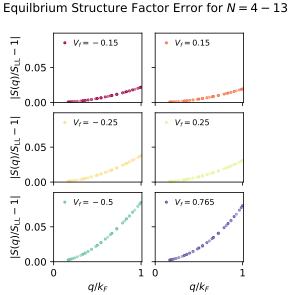

In [6]:
fig, axes = plt.subplots(3,2,sharex=True, sharey=True, squeeze=True, figsize=(fig_size[0],2*fig_size[1]))
axes = axes.flatten()

for iV,cVf in enumerate(Vp):
    
    K = quench.KV(cVf)

    for cN in N[:]:
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn,bc=bc)

        col = colortools.get_alpha_hex(colors[iV],cN/np.max(N))
        props = {'mec':col,'mew':1.0, 'ls':'None','ms':2,
                 'mfc':colortools.get_alpha_hex(colors[iV],0.5), 'color':col, 'lw':1.0}
        
        if key_eq in q_eq:
            SLL_analytical = K*np.abs(q_eq[key_eq])/(2.0*kF)
            #SLL_analytical[0] = S_eq[key_eq][0].real
            if cN == N[-1]:
                label = f'$V_f = {cVf}$'
            else:
                label = ''
            
            ΔS_eq = np.abs((S_eq[key_eq].real-SLL_analytical)/SLL_analytical)
            axes[iV].plot(q_eq[key_eq]/kFN[key],ΔS_eq, marker='o',label=label, **props)

        # Axis Labels 
        if not iV % 2:
            axes[iV].set_ylabel(r'$|S(q)/S_{\rm LL}-1|$')

        if iV >3:
            axes[iV].set_xlabel(r'$q/k_F$')
         
        
    axes[iV].legend(frameon=False, fontsize=8, handletextpad=0.05, loc=(0.0,0.75))

axes[0].set_xlim(0,1.01)
axes[0].set_ylim(0,0.099)
fig.subplots_adjust(hspace=0.15, wspace=0.15)
fig.suptitle('Equilbrium Structure Factor Error for $N=4-13$');

### Normalize the time dependent structure factor by its equilibrium value

In [7]:
S̄ = defaultdict(list)
q = {}
kF_index = {}

for iV,cVf in enumerate(Vf):
    K = quench.KV(cVf)
    
    for cN in N:
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        
        if key in g2:

            x = np.arange(2*cN)
            Δx = x[1]-x[0]
            q[key] = 2*π*np.fft.rfftfreq(x.size,Δx)
            q[key][0] = 1E-16
            
            kF_index[key] = np.where(q[key]>=kFN[key])[0][0]
            
            SLL_analytical = K*np.abs(q[key])/(2.0*kF) 
            
            # here we use the empirical (measured) value
            SLL = S_eq[key_eq]
        
            len_t = len(g2[key][:,0])
            S̄[key] = np.array([(1.0 + ρ*np.fft.rfft(g2[key][it,1:]-1.0).real)/SLL for it in range(len_t)])
            

### Examining the Structure Factor at Short Times $t \cdot J = 1/2$ for $N = 13$

Text(0.5, 0, '$q/k_{\\rm F}$')

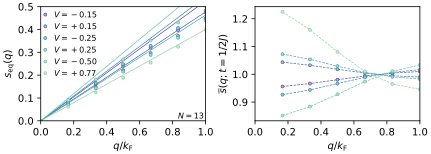

In [8]:
ncolors = colortools.get_linear_colors('Spectral',20,reverse=True)
fig, axes = plt.subplots(1,2,sharex=True, sharey=False, squeeze=True, figsize=(2*fig_size[0],fig_size[1]))
fig.subplots_adjust(wspace=0.3)

q_th = np.linspace(0,2,1000)
for iV,cVf in enumerate(Vp):

    for cN in N[-1:]:
        key = quench.lookup(cN,Vi,cVf,Δt,cn,bc='PBC')
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn,bc='PBC')

        props = {'mec':ncolors[iV],'mew':0.7,'ms':3,
                 'mfc':colortools.get_alpha_hex(ncolors[iV],0.5), 'color':ncolors[iV], 'lw':0.7}
        
        if key_eq in q_eq:
            axes[0].plot(q_eq[key_eq]/kFN[key],S_eq[key_eq].real, marker='o', label=f'$V = {cVf:+.2f}$', ls='None', **props)
            
            ## The LL Prediction
            K = quench.KV(cVf)
            axes[0].plot(q_th,K*q_th/(2.0), lw=0.7,color=ncolors[iV], linestyle='-', zorder=-1)
        
        if key in S̄:
            idx = np.where(np.abs(g2[key][:,0]-1/2)<Δt)[0][0]
            axes[1].plot(q[key][1:]/kFN[key],S̄[key][idx,1:], marker='o', label=f'$V_f = {cVf:+.2f}$', linestyle='--',**props)

axes[0].text(0.99,0.02,f'$N = {cN}$',transform=axes[0].transAxes, fontsize=8, ha='right')
axes[0].set_xlabel(r'$q/k_{\rm F}$')
axes[0].set_ylabel(r'$s_{\rm eq}(q)$')
axes[0].legend(loc=(-0.04,0.35),frameon=False, fontsize=8, handletextpad=0.1)
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,0.5)

axes[1].set_ylabel(r'$\overline{s}(q;t= 1/2J)$')
axes[1].set_xlabel(r'$q/k_{\rm F}$')

### Comparison of Pre and Post Quench Structure Factor

\begin{equation}
\bar{s}(q; t)-1 \equiv \frac{s(q; t)}{K |q|/(2k_{\rm F})}-1  =   
\alpha + \beta \cos(\gamma t) + \delta \, t
\end{equation}

where from the LL prediction:

\begin{align}
 \alpha & = 2 n_q = \frac{1}{2}(K + K^{-1} - 2)\\
 \beta &= \frac{1}{2}(K + K^{-1}) \\
 \gamma &= 2 \omega_q = 2 v q
\end{align}

In [9]:
def S_post_quench(q,kF,cV,t):

    K = quench.KV(cV)
    SLL = K*np.abs(q)/(2*kF)
    nq = 0.25*(K + 1/K - 2)
    
    return SLL*(1.0 + 2*nq + (1/K-K)/2 * np.cos(2*q*quench.tscalefactor(cV)*t))

## Publication Plot Figure 01
----

0.25022262724227384
39


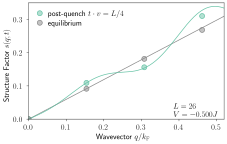

In [10]:
ncolors = colortools.get_linear_colors('Spectral',20,reverse=True)

plt.style.reload_library()
with plt.style.context(style_file):
    fig, axes = plt.subplots(1,1,)

    q_th = np.linspace(0,2,1000)
    cVf = -0.5
    cN = 13
    non_eqm_color = colors[Vp.index(cVf)]
    eqm_color = '#888888'
    key = quench.lookup(cN,Vi,cVf,Δt,cn,bc='PBC')
    key_eq = quench.lookup(cN,cVf,cVf,Δt,cn,bc='PBC')
    
    if key in S̄:
        
        idx = np.where(g2[key][:,0]*quench.tscalefactor(cVf)/(2*cN)>0.25)[0][0]
        ct = g2[key][idx,0]
        print(g2[key][idx,0]*quench.tscalefactor(cVf)/(2*cN))
        print(idx)
        axes.plot(q[key]/(kF),S̄[key][idx,:]*S_eq[key_eq], marker='o', label=r'post-quench  $t \cdot v = L/4$', linestyle='None', 
                  mfc=non_eqm_color+'80',mec=non_eqm_color, mew=0.7, ms=5, color=non_eqm_color)
        
        # plot the theory prediction
        label = r'$ s_{LL}(q) [ 2 \langle n_q \rangle + 1 + \sinh(2 \beta_q) \cos(2 \omega_q t)] $'
        axes.plot(q_th/kF,S_post_quench(q_th,kF,cVf,ct),color=non_eqm_color, lw=0.7 )
    
    if key_eq in q_eq:
        axes.plot(q_eq[key_eq]/(kF),S_eq[key_eq].real, marker='o', label='equilibrium', ls='None', mec=eqm_color, 
                  mfc=eqm_color+'80', ms=5, mew=0.7)
            
        ## The LL Prediction
        K = quench.KV(cVf)
        axes.plot(q_th/kF,K*q_th/(2.0*kF), lw=0.7,color=eqm_color, linestyle='-', zorder=-1)

    lab = f'$L = {2*cN}$      ' + '\n' + f'$V = {cVf:.3f}J$'# + '\n' f'$K = {K:.3f}$ '

    axes.text(0.74,0.02,lab,transform=axes.transAxes, fontsize=8, ha='left')
    axes.set_xlabel(r'Wavevector  $q/k_{\rm F}$')
    axes.set_ylabel(r'Structure Factor $s(q;t)$')
    axes.legend(loc='upper left',frameon=False, fontsize=8, handletextpad=0.5, handlelength=1)
    axes.set_xlim(0,0.52)
    axes.set_ylim(0,0.35)

    plt.savefig(f'../figures/S_vs_q_N_{cN}.pdf')
    plt.savefig(f'../figures/S_vs_q_n_{cN}.svg')

## Analyze the boson momentum distribution at each $q$

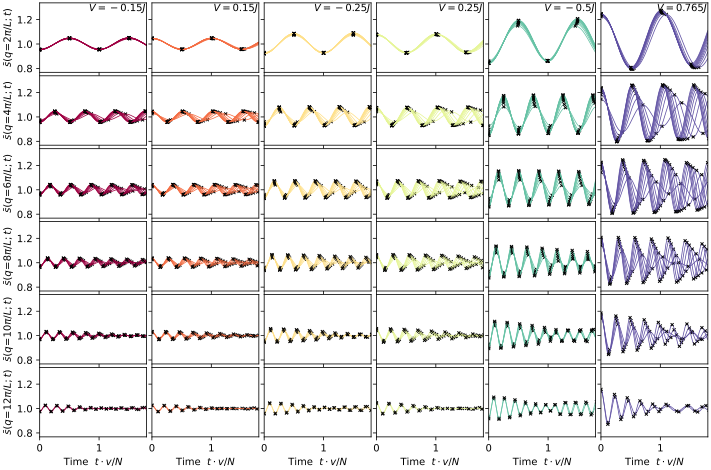

In [18]:
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy import integrate

fig, axes = plt.subplots(6,6,sharex=True, sharey=True, squeeze=True, figsize=(12,8))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ncolors = colortools.get_linear_colors('Spectral',2*len(N),reverse=True)

# an arbitrary cut-off for the end of the interpolation
t_cut = 500

ωq,Δωq = defaultdict(list),defaultdict(list)
δ,Δδ = defaultdict(list),defaultdict(list)
nLL_ext,ΔnLL_ext = defaultdict(list),defaultdict(list)

for iV,cVf in enumerate(Vp):
    K = quench.KV(cVf)
    Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
    props = {'color':colors[iV],'marker':'None', 'ls':'-','lw':0.75}
    props1 = {'mec':colors[iV],'mew':0.25, 'ls':'None','ms':2, 'mfc':'None', 'marker':'o'}

    for cN in N[:]:
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        K = quench.KV(cVf)

        if key in S̄:
            for q_index,cq in enumerate(q[key]):
                
                # get the time dependent n(q,t) data and perform an interpolation
                y = S̄[key][:t_cut,q_index] - 1
                t = g2[key][:t_cut,0]*quench.tscalefactor(cVf) # t · J → t · v
                
                _y_spline = interp1d(t, y, kind='cubic')
                t_spline = np.arange(0,t[-1],0.0005)
                y_spline = _y_spline(t_spline)
                
                zero_crossing = np.where(np.diff(np.signbit(y_spline)))[0][0]
                max_idx = argrelextrema(y_spline[zero_crossing:], np.greater)[0]+zero_crossing
                min_idx = argrelextrema(y_spline[zero_crossing:], np.less)[0]+zero_crossing
                
                t_idx = np.zeros(1,dtype='int')
                t_idx = np.append(t_idx,max_idx)  # maxima
                t_idx = np.append(t_idx,min_idx)  # minima
                t_idx = np.sort(t_idx) # ordering
                
                # Extract the frequency
                γ_ext = []
                jmax = 4
                for j in range(1,jmax):
                    γ_ext.append(j*π/t_spline[t_idx[j]]) 
          
                ωq[key].append(np.average(γ_ext)/2)
                Δωq[key].append(np.std(γ_ext)/2/np.sqrt(len(γ_ext)))
                
                # Compute a possible time-dependent drift
                I = []
                for j in range(1,jmax):
                    I.append(integrate.simps(y_spline[:t_idx[j]+1],t_spline[:t_idx[j]+1])/t_spline[t_idx[j]+1])
                    
                δ_ext = [None]*(jmax-1)
                δ_ext[0] = (2*2*ωq[key][-1]/π)*(I[1]-I[0])
                δ_ext[1] = (2*2*ωq[key][-1]/π)*(I[2]-I[1])
                δ_ext[2] = (2*ωq[key][-1]/π)*(I[2]-I[0])
                
                δ[key].append(np.average(δ_ext))
                Δδ[key].append(np.std(δ_ext)/np.sqrt(len(δ_ext)))
                
                # now extract n(q) from the integrated values
                α_ext = [None]*(jmax-1) 
                α_ext[0] = (2*I[0] - I[1])/2
                α_ext[1] = (0.5*(3*I[0] - I[2]))/2
                α_ext[2] = (3*I[1]-2*I[2])/2
                
                nLL_ext[key].append(np.average(α_ext))
                ΔnLL_ext[key].append(np.std(α_ext)/np.sqrt(len(α_ext)))
            
                if 1 <= q_index <= kF_index[key]:
                    axes[q_index-1,iV].plot(t_spline/cN,y_spline+1, **props, label='ED data')
                    #axes[q_index-1,iV].plot(t/cN,y+1, **props1, label='ED data')
                    axes[q_index-1,iV].plot(t_spline[t_idx]/(cN),y_spline[t_idx]+1, 'x', color='k', ms=3)
                    
                    #axes[q_index-1,iV].plot(t_spline[zero_crossing]/cN,1.0, '*')

axes[0,0].set_xlim(0,1.8);

for i in range(axes.shape[1]):
    axes[-1,i].set_xlabel(r'Time  $t \cdot v / N$')
    axes[0,i].text(0.99,0.99,f'$V = {Vp[i]}J$',transform=axes[0,i].transAxes, ha='right', va='top')
    
qlab = '2'
for i in range(axes.shape[0]):
    if i > 0:
        qlab = f'{(i+1)*2}'
    axes[i,0].set_ylabel(r'$\bar{{s}}(q\!=\!{:s}\pi/L;t)$'.format(qlab))

## Plot the $q = 2\pi/L$ Curves

## Publication Plot Figure 02
----

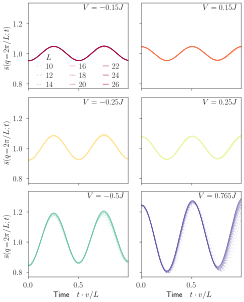

In [12]:
with plt.style.context(style_file):
    fig, axes = plt.subplots(3,2,sharex=True, sharey=True, squeeze=True, 
                             figsize=(1*fig_size[0],2*fig_size[1]), constrained_layout=True)
    axes = axes.flatten()
    #plt.subplots_adjust(hspace=0.1)

    for iV,cVf in enumerate(Vp):
            
        K = quench.KV(cVf)
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        props = {'color':colors[iV],'marker':'None', 'ls':'--','lw':0.5}

        for cN in N[:]:
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
            K = quench.KV(cVf)

            if key in S̄:
                q_index = 1

                # get the time dependent n(q,t) data and perform an interpolation
                y = S̄[key][:t_cut,q_index] - 1
                t = g2[key][:t_cut,0]*quench.tscalefactor(cVf) # t · J → t · v

                _y_spline = interp1d(t, y, kind='cubic')
                t_spline = np.arange(0,t[-1],0.0005)
                y_spline = _y_spline(t_spline)
                
                m = (1-0.1)/(N[-1]-N[0])
                b = 1 - m*N[-1]
                α = m*cN + b
                
                lab = f'${2*cN}$'
                if cN == 4:
                    lab = ''
                    
                axes[iV].plot(t_spline/(2*cN),y_spline+1, **props, label=lab, dashes=(3,0.5*(N[-1]-cN)),
                             alpha=α)
        
        axes[iV].text(0.99,0.985,f'$V = {Vp[iV]}J$',transform=axes[iV].transAxes, ha='right', va='top', fontsize=8)
        if not iV % 2:
            axes[iV].set_ylabel(r'$\bar{{s}}(q\!=\!2\pi/L;t)$')
            
        
    axes[0].set_xlim(0,0.99);
    [axes[iV].set_xlabel(r'Time$\quad t \cdot v / L$') for iV in range(4,6)] 
    
    loc = (0.0,0.45)
    loct = 0.125,0.9
    
    loc = (0.05,-0.035)
    loct = 0.175,0.4
    axes[0].legend(loc=loc,handletextpad=0.4, handlelength=0.7,labelspacing=0.25, ncol=3)
    axes[0].text(*loct,f'$L$',transform=axes[0].transAxes, ha='left', va='top')

    plt.savefig(f'../figures/nqt_vs_t_with_interp.pdf')
    plt.savefig(f'../figures/nqt_vs_t_with_interp.svg')

## Extract $n_q$, $\omega(q)$ and $\delta$ as a function of $q$

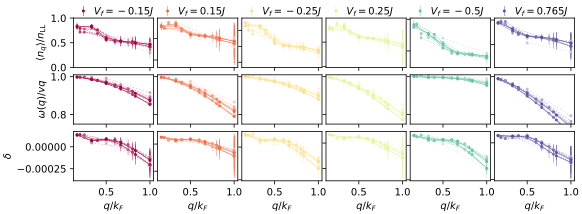

In [13]:
fig, axes = plt.subplots(3,6,sharex=True, figsize=(9,3))

S_from_nq, ΔS_from_nq = {},{}
S_fss_even,S_fss_odd = defaultdict(list),defaultdict(list)
ΔS_fss_even,ΔS_fss_odd = defaultdict(list),defaultdict(list)

S_fss,ΔS_fss = defaultdict(list),defaultdict(list)

for iV,cVf in enumerate(Vp):
    
    K = quench.KV(cVf)
    n0 = 0.25*(K+1/K-2)
    Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)

    for cN in N[:]:
        key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)
            
        # we get all values q>0 and q <= kF
        stop = kF_index[key] + 1
        _nq = np.array(nLL_ext[key][1:stop])
        _Δnq = np.array(ΔnLL_ext[key][1:stop])
        
        # we do some simple error propagation to estimate the error
        # in the entropy
        Δln_nq = _Δnq/_nq
        Δlnp_nq = _Δnq/(1+_nq)
        Δprod_p2 = (_nq*np.log(_nq))**2 * ( (_Δnq/_nq)**2 + (Δln_nq/np.log(_nq))**2 )
        Δprod_m2 = ((1+_nq)*np.log(1+_nq))**2 * ( (_Δnq/(1+_nq))**2 + (Δlnp_nq/np.log(1+_nq))**2 )

        S_from_nq[key] = -(2.0/cN)*np.sum(_nq*np.log(_nq) - (1+_nq)*np.log(1+_nq))
        ΔS_from_nq[key] = (2.0/cN)*np.sqrt(np.sum(Δprod_p2 + Δprod_m2))
        
        S_fss[Vkey].append(S_from_nq[key])
        ΔS_fss[Vkey].append(ΔS_from_nq[key])

        # we break into even and odd for ease of plotting. We modify the even case due to the different kF.
        if cN % 2:
            S_fss_odd[Vkey].append(S_from_nq[key])
            ΔS_fss_odd[Vkey].append(ΔS_from_nq[key])
        else:
            cS = (-1)*(np.sum(_nq*np.log(_nq) - (1+_nq)*np.log(1+_nq)) + np.sum(_nq[:-1]*np.log(_nq[:-1]) - (1+_nq[:-1])*np.log(1+_nq[:-1])))/cN
            S_fss[Vkey][-1] = cS 
            S_fss_even[Vkey].append(cS)
            ΔS_fss_even[Vkey].append(ΔS_from_nq[key])

        col = colortools.get_alpha_hex(colors[iV],cN/np.max(N))
        props = {'mec':col,'mew':1.0, 'ls':'None','ms':2, 'marker':'o', 'ecolor':col,
                 'mfc':col, 'color':col, 'lw':0.5, 'elinewidth':0.5}
        
        dash_props = {'color':col,'marker':'None', 'ls':'--','lw':0.5,'dashes':(3,0.5*(N[-1]-cN)) }
        
        if key in nLL_ext:
            kF_idx = kF_index[key]+1

            if cN == N[-1]:
                label = f'$V_f = {cVf}J$'
            else:
                label = ''
                
            axes[0,iV].errorbar(q[key][1:kF_idx]/kFN[key],nLL_ext[key][1:kF_idx]/n0, yerr=ΔnLL_ext[key][1:kF_idx]/n0,label=label, **props)
            axes[1,iV].errorbar(q[key][1:kF_idx]/kFN[key],ωq[key][1:kF_idx]/q[key][1:kF_idx], yerr=Δωq[key][1:kF_idx]/q[key][1:kF_idx], **props)
            axes[2,iV].errorbar(q[key][1:kF_idx]/kFN[key],δ[key][1:kF_idx], yerr=Δδ[key][1:kF_idx], **props)        
            
            # for custom dashes
            axes[0,iV].plot(q[key][1:kF_idx]/kFN[key],nLL_ext[key][1:kF_idx]/n0, **dash_props)
            axes[1,iV].plot(q[key][1:kF_idx]/kFN[key],ωq[key][1:kF_idx]/q[key][1:kF_idx], **dash_props)
            axes[2,iV].plot(q[key][1:kF_idx]/kFN[key],δ[key][1:kF_idx], **dash_props)
    axes[0,iV].legend(frameon=False, handletextpad=0.05, loc=(-0.05,0.95))

axes[0,0].set_ylim(0,1)
axes[0,0].set_ylabel(r'$\langle n_q \rangle/n_{\rm LL}$')
axes[1,0].set_ylabel(r'$\omega(q)/vq$')
axes[2,0].set_ylabel(r'$\delta$')

for i in range(axes.shape[1]):
    axes[-1,i].set_xlabel(r'$q/k_F$')
    
for i in range(axes.shape[1]):
    axes[1,i].set_ylim(0.75,1.01)
    
for j in range(axes.shape[0]):
    for i in range(1,axes.shape[1]):
        axes[j,i].set_yticklabels([])
        
fig.subplots_adjust(hspace=0.15, wspace=0.05)
#fig.suptitle('Equilbrium Structure Factor Error for $N=4-13$');

S_fss[Vkey] = np.array(S_fss[Vkey])
ΔS_fss[Vkey] = np.array(ΔS_fss[Vkey])

S_fss_odd[Vkey] = np.array(S_fss_odd[Vkey]) 
ΔS_fss_odd[Vkey] = np.array(ΔS_fss_odd[Vkey])
S_fss_even[Vkey] = np.array(S_fss_even[Vkey])
ΔS_fss_even[Vkey] = np.array(ΔS_fss_even[Vkey])

## Perform a finite size extrapolation towards $q\to 0$ to extract $n_q$

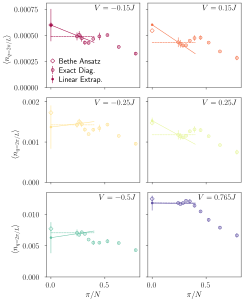

In [14]:
nq_fss,Δnq_fss = defaultdict(list),defaultdict(list)
q_min = defaultdict(list)

nq_extrap,Δnq_extrap = {},{}
q_fit = np.linspace(0,0.4,1000)

plt.style.reload_library()
with plt.style.context(style_file):
    fig, axes = plt.subplots(3,2,sharex=True, sharey=False, squeeze=True, figsize=(1*fig_size[0],2*fig_size[1]),
                            constrained_layout=True)
    axes = axes.flatten()

    for iV,cVf in enumerate(Vp):

        props = {'mec':colors[iV],'mew':0.5, 'ls':'None','ms':3, 'ecolor':colors[iV],
                     'mfc':colortools.get_alpha_hex(colors[iV],0.5)+ '80', 'lw':0.5, 'elinewidth':0.5}

        K = quench.KV(cVf)
        n0 = 0.25*(K+1/K-2)
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)

        for cN in N[:]:
            key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)
            nq_fss[Vkey].append(nLL_ext[key][1])
            Δnq_fss[Vkey].append(ΔnLL_ext[key][1])
            q_min[Vkey].append(q[key][1])

        nq_fss[Vkey] = np.array(nq_fss[Vkey])
        Δnq_fss[Vkey] = np.array(Δnq_fss[Vkey])
        q_min[Vkey] = np.array(q_min[Vkey])

        axes[iV].errorbar(q_min[Vkey],nq_fss[Vkey], yerr=Δnq_fss[Vkey], **props, label='Exact Diag.', marker='o')
        axes[iV].plot(0,n0,marker='D', linestyle='None', ms=3, mfc='None',
                         color=colors[iV], mec=colors[iV], mew=0.5, label='Bethe Ansatz')

        # perform a linear fit
        fit_start = -3
        fit_data = nq_fss[Vkey][fit_start:]
        fit_var = q_min[Vkey][fit_start:]

        p,Δp = np.polyfit(fit_var,fit_data,1,cov=True)
        nq_extrap[Vkey] = p[1]
        Δnq_extrap[Vkey] = np.sqrt(Δp[1,1])

        axes[iV].plot(q_fit,np.poly1d(p)(q_fit),'-',color=colors[iV], lw=0.5)
        
        props = {'mec':colors[iV],'mew':0.5, 'ls':'None','ms':2, 'ecolor':colors[iV],
                     'mfc':colors[iV], 'lw':0.5, 'elinewidth':0.5}
        axes[iV].errorbar(0.0,nq_extrap[Vkey], yerr=Δnq_extrap[Vkey], **props, marker='o', label='Linear Extrap.')

        axes[iV].plot(q_fit,fit_data[-1]*np.ones_like(q_fit),'--',color=colors[iV], lw=0.5)

        if iV % 2:
            axes[iV].axes.yaxis.set_ticklabels([])
        else:
            axes[iV].set_ylabel(r'$\langle n_{q = 2\pi/L} \rangle$')

        axes[iV].text(0.985,0.98,f'$V = {cVf}J$',transform=axes[iV].transAxes, ha='right', va='top', fontsize=8)

    #axes.set_ylabel('Boson Number Density  ' + r'$n_{q=\pi/N}$')
    #axes.set_xlabel('Minimum Wavevector  ' + r'$q=\pi/N$')

    [ax.set_ylim(0,0.00081) for ax in axes[:2]];
    [ax.set_ylim(0,0.0021) for ax in axes[2:4]];
    [ax.set_ylim(0,0.0135) for ax in axes[4:]];

    [ax.set_xlabel(r'$\pi/N$') for ax in axes[4:]];
    axes[0].legend(loc=(0.0,0.01),handletextpad=0.4, handlelength=0.7,labelspacing=0.25)

### Put this figure on a single axis

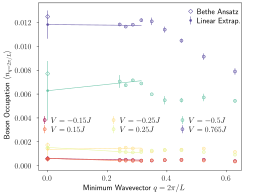

In [15]:
plt.style.reload_library()
q_fit = np.linspace(0,π/10,1000)
eb = []

with plt.style.context(style_file):
    fig, axes = plt.subplots(1,1,sharex=True, sharey=False, squeeze=True, figsize=(fig_size[0],4/5*fig_size[0]),
                            constrained_layout=True)

    for iV,cVf in enumerate(Vp):

        props = {'mec':colors[iV],'mew':0.5, 'ls':'None','ms':3, 'ecolor':colors[iV],
                     'mfc':colortools.get_alpha_hex(colors[iV],0.5)+ '80', 'lw':0.5, 'elinewidth':0.5}

        K = quench.KV(cVf)
        n0 = 0.25*(K+1/K-2)
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)

        _eb = axes.errorbar(q_min[Vkey],nq_fss[Vkey], yerr=Δnq_fss[Vkey], **props, marker='o', label=f'$V = {cVf}J$')
        eb.append(_eb)
        
        ba, = axes.plot(0,n0,marker='D', linestyle='None', ms=3, mfc='None',                 
                         color=colors[iV], mec=colors[iV], mew=0.5, label='Bethe Ansatz')
        # perform a linear fit
        fit_start = -3
        fit_data = nq_fss[Vkey][fit_start:]
        fit_var = q_min[Vkey][fit_start:]

        p,Δp = np.polyfit(fit_var,fit_data,1,cov=True)

        axes.plot(q_fit,np.poly1d(p)(q_fit),'-',color=colors[iV], lw=0.5)
        
        props = {'mec':colors[iV],'mew':0.5, 'ls':'None','ms':2, 'ecolor':colors[iV],
                     'mfc':colors[iV], 'lw':0.5, 'elinewidth':0.5}
        extrap = axes.errorbar(0.0,nq_extrap[Vkey], yerr=Δnq_extrap[Vkey], **props, marker='o', label='Linear Extrap.')

        axes.set_ylabel(r'$\langle n_{q = 2\pi/L} \rangle$')

    axes.set_ylabel('Boson Occupation  ' + r'$\langle n_{q=2\pi/L}\rangle$')
    axes.set_xlabel('Minimum Wavevector  ' + r'$q=2\pi/L$')
    
    axes.set_xlim(-0.03,0.65)

    legend1 = plt.legend(handles=[ba,extrap], loc=(0.72,0.85),handletextpad=0.4, handlelength=0.7,labelspacing=0.25)
    plt.gca().add_artist(legend1)

    plt.legend(handles=eb, loc=(0.0,0.2),handletextpad=0.4, handlelength=0.7,labelspacing=0.25, ncol=3)

## Compare the extracted $n_q$ with the predicted one

## Publication Plot Figure 03
----

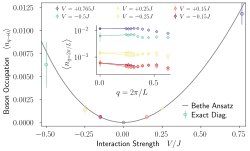

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
import matplotlib as mpl

cts_V = np.linspace(-0.64,0.8,100)
K_BA = quench.KV(cts_V)
nq_BA = 0.25*(K_BA+1/K_BA-2)

q_fit = np.linspace(0,π/10,1000)
eb = []

plt.style.reload_library()
with plt.style.context(style_file):
    fig, ax = plt.subplots(1,1,constrained_layout=True)
    
    ax.plot(cts_V,nq_BA,'-', color='gray', lw=0.75, label='Bethe Ansatz', zorder=-10)
    
    for iV,cVf in enumerate(Vp):
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        
        props = {'mec':colors[iV],'mew':0.5, 'ecolor':colors[iV], 'elinewidth':0.5, 'ls':'None','ms':3,
                      'mfc':colortools.get_alpha_hex(colors[iV],0.5)+'80', 'marker':'o'}
        
        if iV == 4:
            label='Exact Diag.'
        else:
            label = ''

        ax.errorbar(cVf,nq_extrap[Vkey],yerr=Δnq_extrap[Vkey], **props, label=label)
        
    ax.plot(0.0,0.0,marker='o', ms=3, mfc='#90909080', mec='#909090',mew=0.5)

    ax.legend(loc='lower right', handletextpad=0.4, handlelength=0.7,labelspacing=0.25)
    ax.set_xlabel('Interaction Strength' + r'$\quad V/J$') 
    ax.set_ylabel('Boson Occupation' + r'$\quad \langle n_{q\to0} \rangle$')
    ax.set_ylim(-0.0004,0.013)
    ax.set_xlim(-0.53,0.79)
    
    # --------------------------------------------------------------------------------
    # Add Inset 
    axins = inset_axes(ax, width="80%", height="80%",
                    bbox_to_anchor=(0.2, .35, .45, .5),
                    bbox_transform=ax.transAxes)
    
    for iV,cVf in enumerate(Vp):

        props = {'mec':colors[iV],'mew':0.4, 'ls':'None','ms':2, 'ecolor':colors[iV],
                     'mfc':colortools.get_alpha_hex(colors[iV],0.5)+ '80', 'lw':0.4, 'elinewidth':0.4}

        K = quench.KV(cVf)
        n0 = 0.25*(K+1/K-2)
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)

        _eb = axins.errorbar(q_min[Vkey],nq_fss[Vkey], yerr=Δnq_fss[Vkey], **props, marker='D', 
                             label=f'$V = {cVf:+}J$')
        eb.append(_eb)

        # perform a linear fit
        fit_start = -3
        fit_data = nq_fss[Vkey][fit_start:]
        fit_var = q_min[Vkey][fit_start:]

        p,Δp = np.polyfit(fit_var,fit_data,1,cov=True)

        axins.plot(q_fit,np.poly1d(p)(q_fit),'-',color=colors[iV], lw=0.5)
        
        props = {'mec':colors[iV],'mew':0.4, 'ls':'None','ms':2, 'ecolor':colors[iV],
                     'mfc':colors[iV], 'lw':0.4, 'elinewidth':0.4}
        extrap = axins.errorbar(0.0,nq_extrap[Vkey], yerr=Δnq_extrap[Vkey], **props, marker='o', 
                                label='Linear Extrap.')

        axins.set_ylabel(r'$\langle n_{q = 2\pi/L} \rangle$')

    axins.set_ylabel(r'$\left\langle n_{q={2\pi}/{L}}\right\rangle$')
    axins.set_xlabel(r'$\quad q=2\pi/L$')
    axins.set_yscale('log')
    axins.spines['right'].set_visible(False)
    axins.spines['top'].set_visible(False)
    
    axins.set_xlim(-0.03,0.65)

    plt.legend(handles=eb[::-1], loc=(-0.6,1.07),handletextpad=0.4, handlelength=0.7,labelspacing=0.4, ncol=3, 
              fontsize=6)

    plt.savefig('../figures/nq_vs_V.pdf')
    plt.savefig('../figures/nq_vs_V.svg')

## Load Asymptotic Steady State Finite Size Scaled Spatial Entanglement Data

The process for generating this data is described in the [repository](https://github.com/DelMaestroGroup/papers-code-EntanglementQuantumQuench) for a related [paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.104.195101) on entanglement after q quantum quench. We have included the pickled data here for convenience. 

In [22]:
with open('../data/S_spatial_TL.pickle', 'rb') as pfile:
    _Vp,See,ΔSee = pickle.load(pfile)
_Vp = np.array(_Vp)
Vp_ = _Vp
See_ = np.array(See)
ΔSee_ = np.array(ΔSee)

idx = np.argsort(Vp_)

## Compute the finite size scaled bosonic entropy

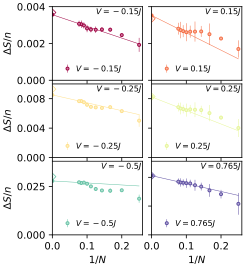

In [23]:
fig, axes = plt.subplots(3,2,sharex=True, sharey=False, squeeze=True, figsize=(1*fig_size[0],2*fig_size[1]))
axes = axes.flatten()

invN_fit = np.linspace(0,0.25,100)

extrap_Sb,Δextrap_Sb = {},{}

for iV,cVf in enumerate(Vp):
    
    K = quench.KV(cVf)
    n0 = 0.25*(K+1/K-2)
    
    Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
    props = {'mec':colors[iV],'mew':1.0, 'ls':'None','ms':3, 'ecolor':colors[iV],
                 'mfc':colortools.get_alpha_hex(colors[iV],0.5), 'color':col, 'lw':0.5, 'elinewidth':0.5}
    
    even = False
    fit_start = -3
    fit_data = S_fss[Vkey][fit_start:]
    
    fit_var = 1/N[fit_start:]
    fit_x = 1.0/N
    
    if even:
        fit_var = np.log(N_even[fit_start:])/N_even[fit_start:]
        fit_data = S_fss_even[Vkey][fit_start:]

        fit_x_even = np.log(N_even)/N_even
        fit_x_odd = np.log(N_odd)/N_odd
 
    try:
        p,Δp = np.polyfit(fit_var,fit_data,1,cov=True)
        Δp = np.sqrt(Δp[1,1])
    except:
        p = np.polyfit(fit_var,fit_data,1,cov=False)
        Δp = 0.0
         
    extrap_Sb[Vkey] = p[1]
    Δextrap_Sb[Vkey] = Δp
    
    axes[iV].plot(0,p[-1], 'o', color=colors[iV], ms=3)
    axes[iV].plot(invN_fit,np.poly1d(p)(invN_fit),'-',color=colors[iV], lw=0.5)
    axes[iV].errorbar(fit_x,S_fss[Vkey], yerr=ΔS_fss[Vkey], **props, label=f'$V = {cVf}J$', marker='o')
    
    # plot the ED data
    idx = np.where(np.abs(_Vp-cVf)<0.01)[0][0]
    axes[iV].errorbar(0.0,See[idx],yerr=ΔSee[idx], marker='D', linestyle='None', ms=5, mfc='None', 
                     color=colors[iV], mec=colors[iV], mew=0.75)

    # Deal with Axes 
    if iV % 2:
        axes[iV].axes.yaxis.set_ticklabels([])
    else:
        axes[iV].set_ylabel(r'$\Delta S/n$')

    axes[iV].legend(frameon=False, fontsize=8, handletextpad=0.05, loc='lower left')
    axes[iV].text(0.985,0.98,f'$V = {cVf}J$',transform=axes[iV].transAxes, ha='right', va='top', fontsize=8)
    
    # manually configure axis
    axes[-2].set_xlabel('$1/N$')
    axes[-1].set_xlabel('$1/N$')
    
    axes[0].set_xlim(0,0.26)
    
    ticks = [0.0,0.004,0.008]
    axes[2].set_yticks(ticks)
    axes[3].set_yticks(ticks)
    
    ticks = [0.0,0.025,0.050]
    axes[4].set_yticks(ticks)
    axes[5].set_yticks(ticks)

    axes[0].set_ylim(0,0.004)
    axes[1].set_ylim(0,0.004)
    axes[2].set_ylim(0,0.01)
    axes[3].set_ylim(0,0.01)
    axes[4].set_ylim(0,0.038)
    axes[5].set_ylim(0,0.064)
    
    fig.subplots_adjust(hspace=0.05, wspace=0.1)


## Compare the results using $n_q$ from the direct calculation of entanglement

### First we look at the relative error

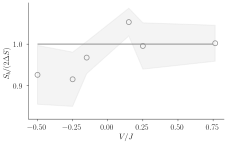

In [24]:
ratio = []
Δratio = []
plt.style.reload_library()
with plt.style.context(style_file):
    
    fig,ax = plt.subplots(1,1)
    for iV,cVf in enumerate(Vp):

        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        idx = np.where(np.abs(_Vp-cVf)<0.01)[0][0]
        
        σ = (extrap_Sb[Vkey]/See[idx])*np.sqrt((Δextrap_Sb[Vkey]/extrap_Sb[Vkey])**2 + (ΔSee[idx]/See[idx])**2)
        ax.plot(cVf,extrap_Sb[Vkey]/See[idx], marker='o', ms=5, mfc='None', mec='#909090', mew=0.75)
        ratio.append(extrap_Sb[Vkey]/See[idx])
        Δratio.append(σ)
     

    sortVp = np.array(Vp)
    idx = np.argsort(sortVp)
    sortVp = sortVp[idx]
    
    ratio = np.array(ratio)
    ratio = ratio[idx]
    Δratio = np.array(Δratio)
    Δratio = Δratio[idx]

    ax.fill_between(sortVp,ratio-Δratio,ratio+Δratio, alpha=0.1, color='#909090')
    ax.hlines(y=1,xmin=-0.5,xmax=0.75, color='#909090', zorder=-10)
    
    ax.set_xlabel(r'$V/J$')
    ax.set_ylabel(r'$S_b/ (2\Delta S)$')
    ax.set_ylim(0.82,1.099)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

### Now we look at the direct comparison
## Publication Plot Figure 04
----

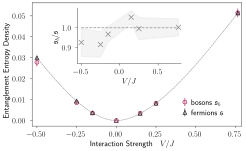

In [28]:
plt.style.reload_library()
V_guide = np.linspace(-0.5,0.76,1000)

with plt.style.context(style_file):
    fig, ax = plt.subplots(1,1,constrained_layout=True)
    plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'
    
    for iV,cVf in enumerate(Vp):

        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        
        # Structure Factor Results
        props = {'mec':colors[0],'mew':0.5, 'ecolor':colors[0], 'elinewidth':0.5, 'ls':'None','ms':4,
                      'mfc':colortools.get_alpha_hex(colors[0],0.5)+'40', 'marker':'o'}
        
        if iV == 0:
            label =r'bosons $\mathfrak{s}_b$'
        else:
            label = ''
        ax.errorbar(cVf,extrap_Sb[Vkey],yerr=Δextrap_Sb[Vkey], **props, label=label)
    
    props1 = {'mec':'#000000','mew':0.5, 'ecolor':'#000000', 'elinewidth':0.5, 'ls':'None','ms':4,
                      'mfc':colortools.get_alpha_hex('#000000',0.5)+'40', 'marker':'^', 'lw':'0.5', 
                      'color':'#000000', 'lw':0.5}
    
    ax.errorbar(Vp_,See,yerr=ΔSee_, **props1, label=r'fermions $\mathfrak{s}$')
    
    # Produce a guide to the eye
    guide = interp1d(Vp_,See_, kind='cubic')
    ax.plot(V_guide, guide(V_guide), color='#909090', lw=0.5, ls='--', zorder=-10)
    

    # add the trivial points at V = 0
    ax.errorbar(0.0,0.0,**props)
    
    # --------------------------------------------------------------------------------
    # Add Inset 
    axins = inset_axes(ax, width="90%", height="60%",
                    bbox_to_anchor=(0.18, .24, .55, .75),
                    bbox_transform=ax.transAxes)# add the inset
    axins.fill_between(sortVp,ratio-Δratio,ratio+Δratio, alpha=0.1, color='#909090')
    axins.plot(sortVp,ratio, marker='x', ms=5, mfc='#909090', mec='#909090', mew=0.75, linestyle='None')

    axins.hlines(y=1,xmin=-0.5,xmax=0.76, color='#909090', zorder=-10, lw=0.76, ls='--')
    
    axins.set_xlabel(r'$V/J$')
    axins.set_ylabel(r'$\mathfrak{s}_b/\mathfrak{s}$')
    axins.set_ylim(0.82,1.099)
    axins.spines['right'].set_visible(False)
    axins.spines['top'].set_visible(False)
    axins.set_xlim(-0.55,0.8)
    

    ax.set_xlabel('Interaction Strength' + r'$\quad V/J$')
    ax.set_ylabel('Entanglement Entropy Density')
    ax.legend(loc=(0.7,0.05), handletextpad=0.4, handlelength=0.7,labelspacing=0.4)
    ax.set_xlim(-0.53,0.79)
    
    plt.savefig('../figures/entropy_comparison.pdf')
    plt.savefig('../figures/entropy_comparison.svg')